# 回帰モデル


### 学籍番号、氏名を入力せよ

- 学籍番号：
- 氏名:

---

## Pythonによる回帰分析

ここでは、探索的データ分析で扱った医療費データの医療費を予測するモデルを解説します。

insurance.csvで列名"charges"を目的変数$y$、その他の列や列から作成した変数を説明変数$x_i,x_2,\cdots,x_p$とします。そして、目的変数$y$の期待値を
説明変数の線形結合で、また、期待値からのズレを誤差$\epsilon$で記述します。
具体的には次の式で$y$を表します。

$$
y=b_0+b_1\cdot x_1+\cdots+b_p\cdot x_p+\epsilon
$$

このモデルを線形回帰モデルと呼びます。特に誤差が正規分布に従う場合、その分散を
$\sigma^2$と書くと、$y$は期待値$b_0+b_1\cdot x_1+\cdots+b_p\cdot x_p$、
分散$\sigma^2$の正規分布に従います。

$$
y\sim N(b_0+b_1\cdot x_1+\cdots+b_p\cdot x_p,\sigma^2)
$$

ここでは、説明変数の選び方、作り方、モデルの評価方法について解説します。
特に、変数の選び方は重要なテーマなので、汎化能力と交差検証を扱う回でさらに
詳しく扱います。

- 探索的データ左分析では以下のステップでデータを分析しました。

1. データの確認：データの大きさ、変数の数、行数、各変数の型を調べる。
2. 欠損値・異常値の確認：欠損値・異常値がないかどうか。あった場合、該当データの削除か補間。
3. 変数の統計と分布：各列の変数の統計量と分布を計算します。
4. 相関関係：変数間の関係、特に目的変数と説明変数の関係。

その結果、目的変数$y$と相関の強い変数として喫煙習慣（SMOKER）、弱い変数として
年齢(age)、BMI(bmi)、Southeast地域(SE)などの変数を用いて次のモデルを考えました。

$$
y=b_0+b_1 \cdot\mbox{age}+b_2 \cdot\mbox{bmi}+b_3\cdot \mbox{SMOKER}+b_4\cdot \mbox{SE}+\epsilon
$$

ここで、SMOKER変数とSE変数はダミー変数で、喫煙習慣ありなら1、なしなら0、
Southeast在住なら1、そうでないなら0となる二値の変数です。

再度、データの散布図行列を確認してみましょう。



## 0.準備

- pandas,matplotlib.pyplot,seaborn,scipy.statsをimportします。短縮名はpd,plt,sns,statsとします。




#### 必要なライブラリをimportせよ。


In [125]:
#分析に必要なライブラリ、モジュールをimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
#回帰分析で使うライブラリ
import statsmodels.formula.api as smf 

#### ヒント

       import pandas as pd
       import numpy as np
       import matplotlib.pyplot as plt
       import seaborn as sns
       import scipy.stats as stats

を実行します。


- データの入力です。insurance.csvをWEBサイト(github)からDLしてデータフレームdfに入力します。sex,smoker,regionはカテゴリ型に指定します。

次のセルを実行しましょう。

In [126]:
#WEB上のcsvデータを読み込んでデータフレームとする。
import pandas as pd
import urllib.request
from io import StringIO
#WEB上のデータのURLを指定
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
#データを読み込む関数を定義
def read_csv(url):
    print(url)
    res = urllib.request.urlopen(url)
    res = res.read().decode("utf-8")
    df = pd.read_csv(StringIO(res))
    return df
df=read_csv(url)
df= df.astype({"sex":"category","smoker":"category","region":"category"})
df.rename(columns={"charges":"y"},inplace=True) # 目的変数の名前をchargesからyに変更
df.info()

https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   y         1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


目的変数の名前をchargesからyに変更しています。


上のモデルでは十分でないことを確認するために、喫煙習慣と性別で散布図行列を色分けしてプロットしてみます。

#### 問題1:喫煙習慣・性別で散布図行列を色分けしてプロットせよ。


#### 問題1(1)喫煙習慣で散布図行列を色分けしてプロットせよ。

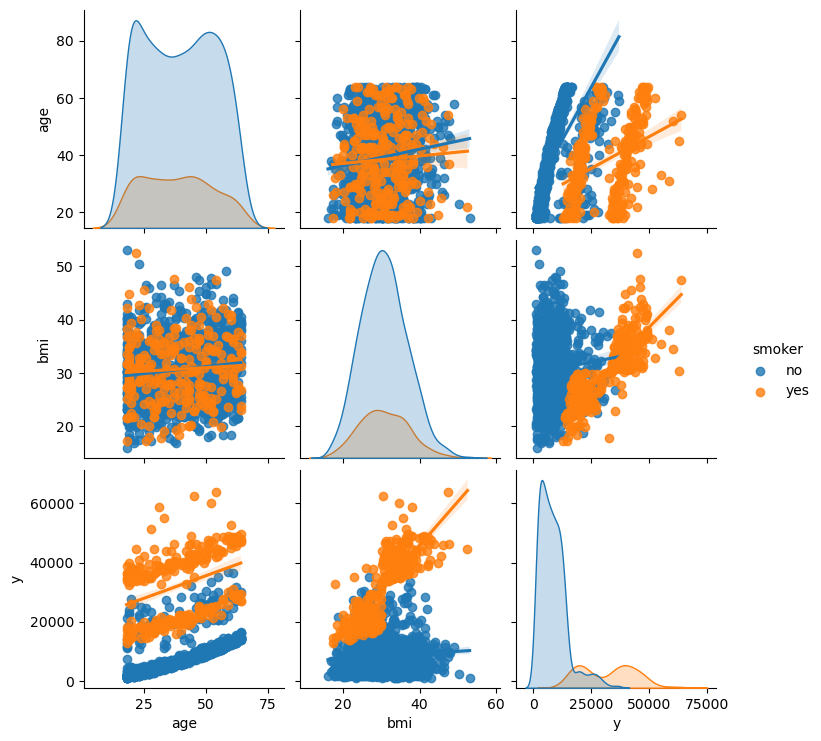

In [127]:
#問題1(1)
#医療費データの量的変数の散布図行列
sns.pairplot(data=df[["age","bmi","sex","smoker","y"]],kind="reg",diag_kind="kde",hue="smoker")
plt.show()

#### 問題1(2)性別で散布図行列を色分けしてプロットせよ。

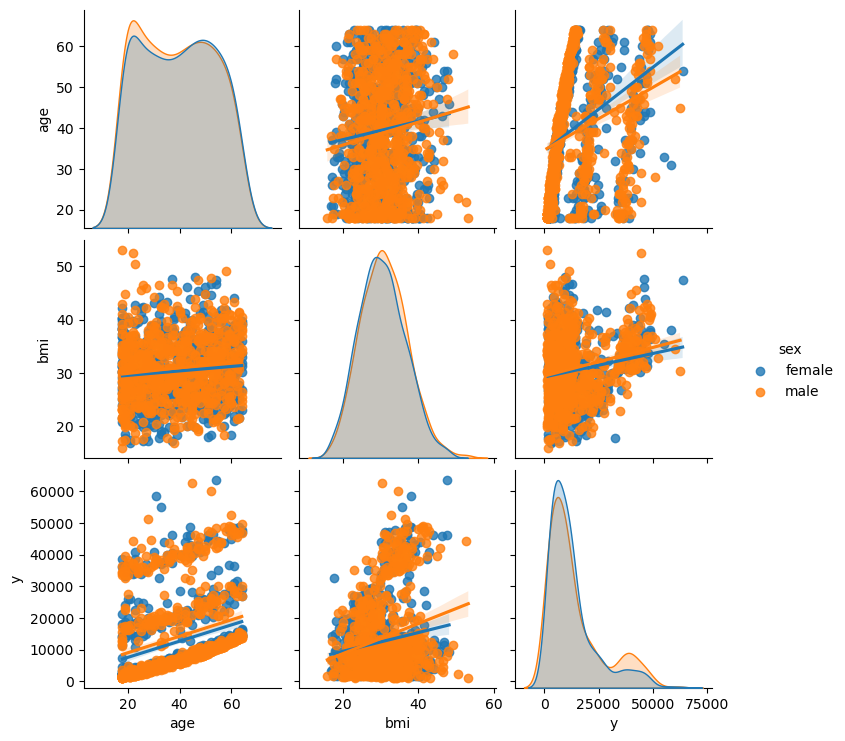

In [128]:
#問題1(2)
sns.pairplot(data=df[["age","bmi","sex","smoker","y"]],kind="reg",diag_kind="kde",hue="sex")
plt.show()

散布図行列を見ると、以下のことに気づくと思います。

1. yの分布をみると、喫煙習慣のあるなしでピーク位置が大きく異なる。喫煙習慣ありの場合、ピークが二つある。

2. bmiが30を超えてくると、喫煙習慣ありの場合に医療費が大きく異なる。喫煙習慣がなしの場合、回帰直線の傾きは小さい。

3. yとageの関係は2次式

1.の喫煙習慣ありの場合の二つのピークを生む要因・質的変数としては、性別かbmi>30か、の二つが考えられます。bmi>30なら1、そうでないなら0となるbmi30という質的変数を作り、データフレームに追加します。




#### 問題1(3)bmi30という変数をdfに追加せよ。

In [129]:
#問題1(3)
#bmi30という変数をdfに追加
df["bmi30"]=df["bmi"]>30
#bmi30カラムを表示
print(df[['bmi30']])

      bmi30
0     False
1      True
2      True
3     False
4     False
...     ...
1333   True
1334   True
1335   True
1336  False
1337  False

[1338 rows x 1 columns]


また、ageの二乗を説明変数として追加します。

このような、探索的データ分析を通して新しい説明変数を追加していくことを特徴量(feature)エンジニアリングと呼びます。

#### 問題1(4)age_sqというageの二乗の変数をdfに追加せよ。

In [130]:
#問題1(4)
#age_sqという変数をdfに追加
df["age_sq"]=df["age"]**2
#age_sqカラムを表示
print(df[['age_sq']])

      age_sq
0        361
1        324
2        784
3       1089
4       1024
...      ...
1333    2500
1334     324
1335     324
1336     441
1337    3721

[1338 rows x 1 columns]


#### bmi30, age_sqカラムを追加したデータフレームを表示してみましょう。

In [131]:
#データフレームの先頭5行を表示
df.head()

,age,sex,bmi,children,smoker,region,y,bmi30,age_sq
0,19,female,27.900,0,yes,southwest,16884.92400,False,361
1,18,male,33.770,1,no,southeast,1725.55230,True,324
2,28,male,33.000,3,no,southeast,4449.46200,True,784
3,33,male,22.705,0,no,northwest,21984.47061,False,1089
4,32,male,28.880,0,no,northwest,3866.85520,False,1024


#### 問題1(5)bmi30で散布図行列を色分けしてプロットせよ。

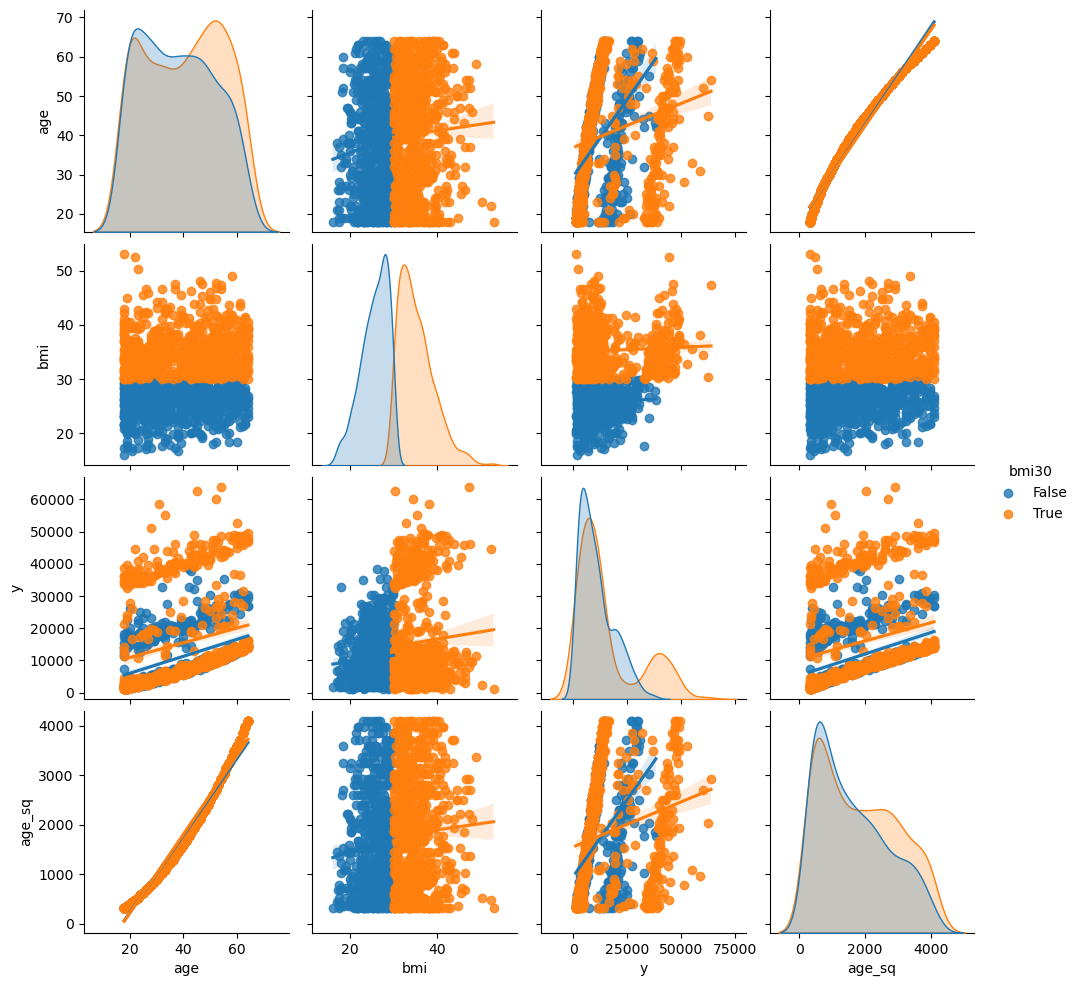

In [132]:
#問題1(5)
#医療費データの量的変数の散布図行列
sns.pairplot(data=df[["age","bmi","sex","smoker","y","bmi30","age_sq"]],kind="reg",diag_kind="kde",hue="bmi30")
plt.show()

bmi30で層別化したデータでの医療費の分布でも40000ドルにピークがあります。

以上から、喫煙習慣、性別、bmi30以上、の3つの質的変数が相互作用して医療費のモデルには入っているようです。また、質的変数と量的変数の相互作用も考えられます。


### 交互作用項

説明変数間の相互作用は、説明変数の積で記述されます。

例えば、smokerと
bmi30の二つの質的変数で$y$を予測する回帰モデルは次の式になります。

$$
y=b_{0}+b_{1}\cdot \mbox{Smoker}+b_2\cdot \mbox{BMI30}+b_{12}\cdot 
\mbox{SMOKER}\times \mbox{BMI30}
$$

このモデルでは$y$の値は4つのパターンで分類されます。

$$
y=\left\{
\begin{array}{cc} 
b_{0} &   \mbox{喫煙習慣なし、BMIが30未満} \\
b_{0}+b_{1} & \mbox{喫煙習慣あり、BMIが30未満}\\
b_{0}+b_{2} & \mbox{喫煙習慣なし、BMIが30以上}\\
b_{0}+b_{1}+b_{2}+b_{12} & \mbox{喫煙習慣あり、BMI30以上}
\end{array}
\right. 
$$

$b_{12}$が喫煙と肥満の相乗効果による医療費の増加を記述します。


また、量的変数ageと質的変数smokerの2変数モデルは次のようになります。
$$
y=b_{0}+b_{1}\cdot \mbox{Smoker}+b_2\cdot \mbox{age}+b_{12}\cdot 
\mbox{SMOKER}\times \mbox{age}
$$
この場合、量的変数ageの前の係数が喫煙習慣がなければ$b_2$、喫煙習慣
があれば$b_{2}+b_{12}$となることが分かります。
$$
y=b_{0}+b_{1}\cdot \mbox{SMOKER}+(b_{2}+b_{12}\mbox{SMOKER})\cdot \mbox{age}
$$

$$
y=\left\{
\begin{array}{cc} 
b_{0}+b_1+(b_2+b_{12})\cdot\mbox{age}  &   \mbox{喫煙習慣あり} \\
b_{0}+b_{2}\cdot \mbox{age} & \mbox{喫煙習慣なし}\\
\end{array}
\right. 
$$


このように、量的変数と質的変数の相互作用により、量的変数の回帰係数が質的変数の値＝層別化された集団ごとに異なる状況を記述できます。

bmiの係数が喫煙集団と非喫煙集団で異なっていたことから、bmiとSMOKER変数の相互作用はあると考えられます。



一般に、説明変数が$x_{i},i=1,\cdots,p$のp個ある場合、2次の相互作用
まで考えると
$$
y=b_{0}+\sum_{i=1}^{p} b_{p}\cdot x_{p}
+\sum_{1\le i\le j\le p}b_{ij}\cdot x_{i}x_{j}+\epsilon
$$
となり、回帰係数は$1+p+p(p+1)/2$個になります。


もちろん3次の項、説明変数$x_i$を関数$\phi(x_i)$で変換したもの、など、説明変数の種類も相互作用も考えると、無限のヴァリエーションがあることになります。

この中でどの変数を回帰モデルにいれるのか、捨てるのか、などの方法については
後に扱います。ここでは、次のモデルをベースに分析を行い、相互作用項を
追加してみましょう。

$$
y=b_0+b_1\cdot\mbox{age}+b_2\cdot\mbox{bmi}+b_{3}\cdot \mbox{children}
+b_{4}\cdot \mbox{SMOKER}+b_{4}\cdot \mbox{BMI30}+b_{5}\cdot \mbox{SE}+
b_{6}\cdot \mbox{SW}+b_{7}\cdot \mbox{NE}+\epsilon
$$

ここで、SMOKER,BMI30,SE,SW,NEはダミー変数,age,bmi,childrenは量的変数です。

## 1.説明変数がひとつの回帰モデル

Pythonを用いた回帰分析になれるために、説明変数がひとつの回帰モデルから説明します。



データ$(x_i,y_i),i=1,\cdots,n$に対して、$y$を目的変数、$x$を説明変数とした回帰モデルは次の式で定義されます。

$$
y_i=b_0+b_1\cdot x_i+\epsilon_i,i=1,\cdots,n
$$

ここで、$\epsilon_i$は誤差項で、目的変数のうち説明変数の一次式で説明できない部分を表しています。$b_{0},b_{1}$を切片、回帰係数と呼び、誤差項が平均0のとき、次の
式で計算することが出来ます。

$$
b_{0}=\overline{y}-b_{1}\cdot \overline{x}
$$

$$
b_{1}=\frac{S_{x,y}}{S_x^2}.
$$

ここで、$\overline{x}$は$x_{i}$の平均値、$\overline{y}$は
$y_{i},i=1,\cdots,n$の平均値です。また、$S_x^2$は$x_{i}$の分散、
$S_{x,y}$は$(x_i,y_i)$の共分散です。



#### 回帰直線

回帰直線とはモデルによる目的変数の推測値を直線で示したものです。

$$
y=b_0+b_1 \cdot x
$$



#### 問題2.$b_0,b_1$を計算し、散布図に回帰直線をプロットしてみます。

(1)$b_0,b_1$を計算して表示せよ。

In [133]:
#問題2(1)
#回帰係数の計算
b1=df[["age","y"]].cov().iloc[0,1]/df["age"].var()
b0=df["y"].mean()-b1*df["age"].mean()
print(b0,b1)

3165.885006063052 257.72261866689485


(2)回帰直線をage,yの散布図にプロットせよ。

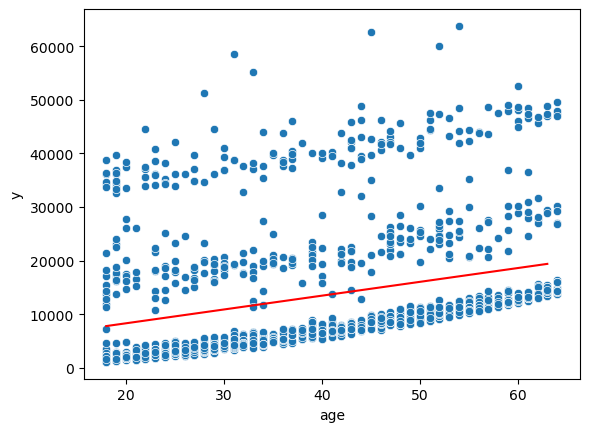

In [134]:
#問題2(2)
#回帰直線の計算
xs=np.arange(df["age"].min(),df["age"].max(),1)
ys=b0+b1*xs
#ageとyの散布図
sns.scatterplot(x="age",y="y",data=df)
#回帰直線を追加
plt.plot(xs,ys,color="r")
plt.show()


#### seabornによる回帰直線の図示

回帰直線はseaboornのImplot関数で描くことができます。

構文は

    sns.lmplot(x="age",y="y",data=df,scatter_kws={"color":"black"} ,line_kws={"color"="black"})


- 散布図に回帰直線を加えたグラフとなります。

- 散布図のデザインの指定はscatter_kws

- 回帰直線のデザインの指定はline_kws

で行います。網掛け部分は回帰直線の95％信頼区間を表しています。

#### 2(3)回帰直線をプロットせよ。

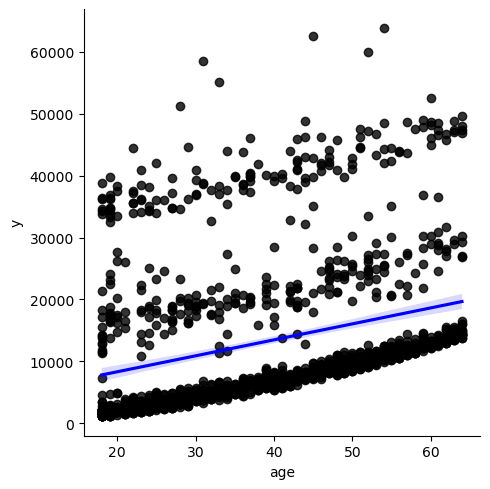

In [135]:
#問題2(3)
#age,yの散布図と回帰直線をsns.lmplot()でプロット
sns.lmplot(x = "age", y = "y", data = df,scatter_kws = {"color": "black"},line_kws    = {"color": "blue"})
plt.show()


### statsmodelsによるモデル化

単回帰モデルを構築します。単回帰モデルを推定するために、

    import statsmodels.formula.api as smf

としてstatsmodelsを読み込みます。これを使うことで簡単にモデルの構築と推定を行うことができます。




具体的には　statsmodels.formula.api(smf)のsmf.ols()関数を使います。

OLSとは最小二乗法(Ordinary Least Square)の略です。


$y$を$x$の1つの説明変数で回帰する単回帰モデルは
$$
y=b_{0}+b_{1}\cdot x+\epsilon
$$
です。


 単回帰モデルの公式では、$\overline{x},\overline{y}$で
$x$と$y$の平均値、 $S_{x,y}$を$x$と$y$の共分散,$S_{x}^2$を$x$の分散とすると、
 次の式で回帰係数を計算しました。


#### statsmodelsの関数で回帰分析

ols()関数で$y$をageで回帰する場合、次のように書いて実行します。


      result = smf.ols(formula = "y ~ age",data = df).fit()




1. formula:モデルの構造を指定するのがformulaです。


    formula= "y ~ age"



と指定することで応答変数が"y",説明変数が"age"であるモデルを指定することになります。

$$
y=b_0+b_{1}\cdot \mbox{age}+\epsilon
$$

formulaを変えることでさまざまなモデルを推定することができます。

2. data:データフレームを指定

    data=df

として対象となるデータフレームdfを指定します。


3. .fit():フィッティングのメソッド

最後の.fit()メソッドは、ols()関数で生成した回帰モデルのオブジェクトに対してパラメータをフィットするメソッドです。返り値は回帰分析の結果です。resultに代入されます。


#### 問題3(1):ols()関数で$y$をageで回帰し、resultに戻り値を代入せよ


In [136]:
#ols()関数で𝑦をageで回帰し、resultに戻り値を代入せよ
import statsmodels.formula.api as smf
result = smf.ols(formula = "y ~ age",data = df).fit()

回帰係数は戻り値のparams変数に入っています。

      result.params

#### 問題3(1)回帰係数を表示せよ。

In [137]:
#問題3(1)
print(result.params)

Intercept    3165.885006
age           257.722619
dtype: float64


### 推定結果の表示

ols()オブジェクトのfitメソッドの出力には回帰係数以外にもさまざまな情報が書き込まれています。見てみましょう。

summary()メソッドで分析結果を表示します。


summary()メソッドで推定結果を表示させます。

#### summary()メソッドでモデルの推定結果を表示

In [138]:
#問題3(2)
#推定結果の表示
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     131.2
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           4.89e-29
Time:                        23:34:12   Log-Likelihood:                -14415.
No. Observations:                1338   AIC:                         2.883e+04
Df Residuals:                    1336   BIC:                         2.884e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3165.8850    937.149      3.378      0.0

まず、次の箇所に注目します。

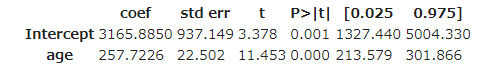

Interceptとageが$b_0,b_1$の推定結果に当たります。Intercept$(b_0)$は切片、$b_1$は回帰直線の傾きです。

- coef列がパラメータの推定値

- std errが標準誤差

線形回帰モデルでは誤差$\epsilon$が正規分布に従っていると仮定し、有限のデータから回帰係数を推定した場合の推定値の分散を評価します。その平方根が標準誤差です。

- t:t値

推定値を標準誤差で割ったものです。推定値がどの程度0から離れているのかの目安になります。

- P>|t|:p値

帰無仮説ではパラメータがゼロとして、誤差が正規分布に従う場合、t値は0を中心とするt分布に従います。このことを用いて、データで計算したｔ値が実現する確率を評価します。それがp値です。

重要なのがageの回帰係数の検定結果です。ageの回帰係数が0なら、この単回帰モデルは意味がないことになります。ageのp値がほぼ0なので、回帰係数がゼロという帰無仮説は棄却されます。

- [0.025が95％信頼係数の信頼区間の下側信頼限界、0.975]が上側信頼限界です。

$b_0,b_1$共に0という帰無仮説は棄却されていますが、信頼区間に0が含まれていないこととも一致しています。


age変数が医療費$y$に影響を与えることは分かりました。係数は約258なので、年齢が1上がると、医療費が258ドル上がると予測できそうです。

この程度の解釈は散布図を見た時点である程度予想はつきました。しかし、説明変数が複数になりモデルが複雑になってくると、モデルを構築してその係数を見たほうが解釈が簡単になります。




#### 誤差の評価

単回帰モデルにおいて誤差$\epsilon$の大きさを評価します。

$$
y=b_0+b_1\cdot x+\epsilon
$$

誤差は平均ゼロと仮定するので、大きさの評価には分散$\sigma^2$を用います。

$$
V[\epsilon]=\sigma^2
$$

$\sigma^2$をデータから推定するには、$y_i$の値から予測値$\mbox{pred}_i=b_0+b_1\cdot x_i$を引いて残差とし、残差平方和を計算します。

$$
e_i=y_i-(\hat{b}_0+\hat{b}_1\cdot x_i)=y_i-\mbox{pred}_i
$$

#### 問題4(1)残差を計算し、統計量をdescribe()で計算して表示せよ。



In [139]:
#問題4(1)
#残差を計算し、errorに代入
error=df["y"]-result.predict()
#統計量をdescribe()で計算
print(error.describe())

count    1.338000e+03
mean     1.172419e-11
std      1.155598e+04
min     -8.059129e+03
25%     -6.671039e+03
50%     -5.939451e+03
75%      5.439740e+03
max      4.782947e+04
Name: y, dtype: float64


残差の統計量から、標準偏差は1.16e04なので１万ドル強のバラツキを持つことが分かります。平均はほぼゼロですが、ゼロになるように$b_0$を選んでいます。

#### 問題4(2)残差のヒストグラムをプロットせよ。

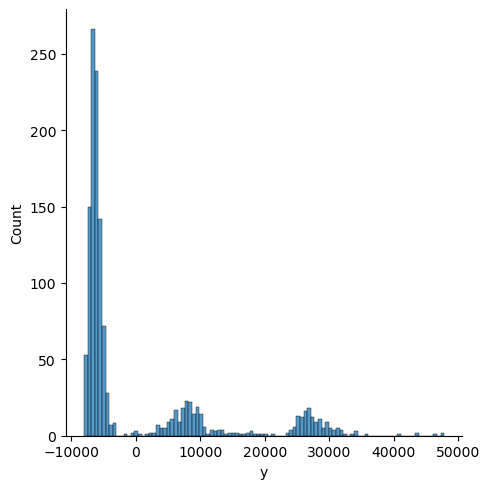

In [140]:
#問題4(2)
sns.displot(error,bins=100)
plt.show()

#### 誤差の大きさ$\sigma^2$の推定

正規線形モデルでは誤差$\epsilon$は平均ゼロの正規分布であることを仮定しますが、
残差の分布を見る限り、正規分布とはほど遠いことが分かります。

残差の平方和を用いて$\sigma^2$を次の公式で推定します。

$$
\frac{1}{n-2}\sum_{i=1}^{n}e_i^2
$$

#### 問題4(3)誤差の分散を推定し、sigma_sqに代入し表示せよ。

In [141]:
#問題4(3)
sigma_sq=np.sum(error**2)/(len(error)-2)
print(sigma_sq)

133640740.55779605


#### RMSE

モデルの誤差の大きさの評価指標としてRMSE(root mean squared error)も用いられます。

$$
\mbox{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^{n}e_i^2}
$$

#### 問題4(4)RMSEを評価してRMSEに代入し、表示せよ。

In [142]:
#問題4(4)
RMSE=np.sqrt(np.mean(error))
print(RMSE)

3.4240602800374214e-06


#### 決定係数

モデルのデータに対する適合度・フィッティングの良さを計測するものが
決定係数$R^2$です。目的変数$y$の平方和のうち、誤差の平方和の割合を求め
1から引いて計算します。

$$
R^2=1-\frac{\sum_{i}e_i^2}{\sum_{i}(y_i-\overline{y})^2}
$$

または、次の恒等式を用いて

$$
\sum_{i}(y_i-\overline{y})^2=\sum_{i}(\mbox{pred}_i-\overline{y})^2+\sum_{i}e_i^2
$$

$$
R^2=\frac{\sum_{i}(\mbox{pred}_i-\overline{y})^2}{\sum_{i}(y_i-\overline{y})^2}
$$

で計算することもできます。

#### 問題4(5) 決定係数を計算してR_sqに代入し、表示せよ。

In [143]:
#問題4(5)
R_sq=1-np.sum(error**2)/np.sum((df["y"]-df["y"].mean())**2)
print(R_sq)

0.08940589967885804


#### 修正決定係数

決定係数はデータとモデルの適合度を計測します。しかし、モデルに
含まれる説明変数の個数＝パラメータ数$p$の増加関数となっています。なぜなら、
説明変数が増えれば増えるほど、それらの線形結合で$目的変数を表現する自由度が
増えるからです。

このため、ある説明変数をモデルに残すべきかどうかを判断する
場合、決定係数は使えません。この問題を解決するのが
修正決定係数です。修正決定係数は説明変数の増加関数ですが、
目的変数と関係ない場合、ほとんど変化しません。ということは、
ある説明変数を追加して修正決定係数が顕著に増加しないなら、
目的変数とは無関係と判断できます。

決定係数では、分母・分子を$n-1$で割ると、分母は$y$の分散の推定値になりますが、分子は誤差の分散の不偏推定値と$(n-2)/(n-1)$倍異なります。そこで、分子の割り算を$n-2$として分散の不偏推定値としたものを修正決定係数$\tilde{R}^2$といいます。

$$
\tilde{R}^2=1-\frac{\sum_{i}e_i^2/(n-2)}{\sum_{i}(y_i-\overline{y})^2/(n-1)}
$$

単回帰モデルの場合、パラメータ数は2個$b_0,b_1$の2個なので、分子はの
残差平方和を$n-2$で割ることで誤差の不偏分散です。一般に、$p$個の説明変数があるモデルでは、Interceptもいれて$p+1$個のパラメータがあるので、分子は$n-p-1$で割りま。

$$
\tilde{R}^2=1-\frac{\sum_{i}e_i^2/(n-p-1)}{\sum_{i}(y_i-\overline{y})^2/(n-1)}
$$







#### 問題4(6)修正決定係数を計算してR_tilde_sqに代入し表示せよ。



In [144]:
#問題4(6)
n=len(error)
R_tilde_sq=1-(np.sum(error**2)/(n-2))/(np.sum((df["y"]-df["y"].mean())**2)/(n-1))
print(R_tilde_sq)

0.08872431726843788


他の出力を見てみます。

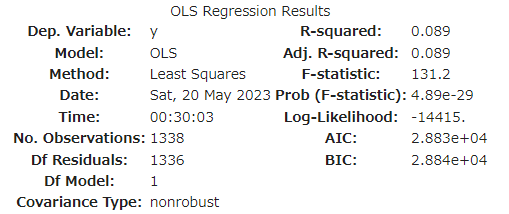

- Dep.Variable:応答変数＝目的変数.DepはDependentで従属変数を意味する.

- Model:OLS=最小二乗法はOrdinary Least Square Methodといい、OLSと略されます。

- Method:通常の最小二乗法を使用

- Date・Time:モデルが推定された日時

- No. Observation:サンプルサイズ

- Df Residuals:サンプルサイズから推定されたパラメータの数を引いたもの

- Df Model:用いられた説明変数の数

- Covariance Type ：共分散のタイプ。

- R-Squared,Adj, R-squared:決定係数と自由度調整済み決定係数

- F-statistics,Prob(F-statistics):分散分析の結果（F値、p値）

- Log-Likelihood:最大化対数尤度

- AIC:赤池の情報量基準

- BIC:ベイズ情報量基準



### モデルによる予測

今回推定した単回帰モデルは次のものでした。

$$
y\sim N(b_0+b_1 \times \mbox{age},\sigma^2)
$$

$b_0,b_1$に推定値を代入します。
推定されたモデルを用いて予測するにはpredictメソッドを使います。引数に何も指定しない場合、訓練データへの当てはめ値が出力されます。

ols()関数でフィットした結果がresultに代入されている場合、

    result.predict()

とすると当てはめ値が計算できます。

#### 問題5(1)

モデルの訓練に用いたデータで予測値(当てはめ値)を計算し、predに代入せよ。そしてdfに"pred"変数として追加せよ。当てはめ値の計算にはpredict()メソッドを用いる。




In [145]:
#問題5(1)
#当てはめ値を計算
pred=result.predict()
df["pred"]=pred
print(df[["pred"]])

              pred
0      8062.614761
1      7804.892142
2     10382.118329
3     11670.731422
4     11413.008803
...            ...
1333  16052.015939
1334   7804.892142
1335   7804.892142
1336   8578.059998
1337  18886.964745

[1338 rows x 1 columns]


当てはめ値と目的変数を散布図として可視化してみます。対角線からのずれが残差でした。

$$
\mbox{残差}=\mbox{目的変数}-\mbox{当てはめ値}
$$

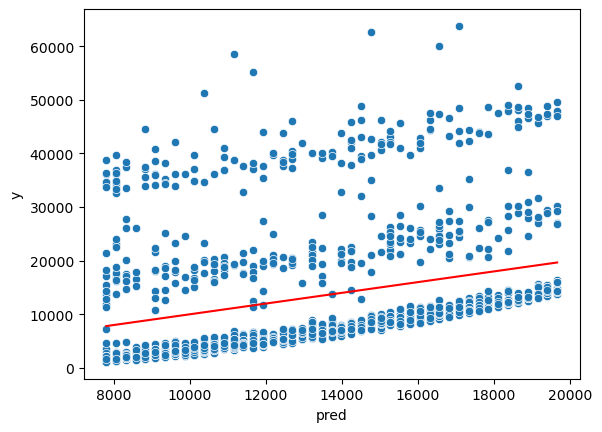

In [146]:
#問題5(2)
#predとyの散布図に回帰直線を追加
sns.scatterplot(x="pred",y="y",data=df)
#対角線をプロット
x_min=pred.min()
x_max=pred.max()
plt.plot([x_min,x_max],[x_min,x_max],color="r")
plt.show()

#### 未知データでの予測

医療費予測の開発の目的は新規加入者の将来の医療費を予測することです。
新規加入者の説明変数の値を入力して、目的変数を計算することが必要です。

$$
y=b_{0}+b_{1}\cdot \mbox{age}
$$
のモデルでは、既存のデータで$b_0,b_1$を推定しています。
そして、ageに新規加入者の年齢を入力して、予測値を計算します。

$$
\mbox{予測値}=b_{0}+b_{1}\cdot \mbox{新規加入者の年齢}
$$

pred()メソッドを用いてageの値を指定して、推定された回帰モデルで予測を行うこともできます。予測値を計算したいageでデータフレームを作成し、predict()の引数にデータフレームを指定します。今回はageが[20,40,60,80]の時の医療費の期待値を計算してみます。

#### 問題5(2)年齢が20,40,60,80の新規加入者の医療費を予測せよ。


In [147]:
#問題5(3)
# データフレームdf_newを作成
df_new=pd.DataFrame({"age":[20,40,60,80]})
#予測値を計算
pred_df_new = result.predict(df_new)
print(pred_df_new)

0     8320.337379
1    13474.789753
2    18629.242126
3    23783.694499
dtype: float64


回帰モデルで推定した$b_0,b_1$の値は属性変数paramsに入っています。

In [148]:
print(result.params[0],result.params[1])

3165.885006063031 257.7226186668951



---

## 2.複数の説明変数を持つモデル


説明変数age,sex,bmi,children,smoker,region,bmi30,age_sqを8つとも入ったモデルを構築します。smoker,sex,region,bmi30はカテゴリ型変数なのでダミー変数で扱います。

region変数はsoutheast,southwest,northeast,northwestの4つの値をとりますが、3つの0,1型のダミー変数で表現できます。他のsex,smoker,bmi30はTrue,Falseの2値なので、1個のダミー変数で表すことができます。

よって、説明変数の個数は全部で10になります。モデルのパラメータ数$p=11$です。





smf.ols関数でモデルのところで説明変数を「+」記号で連結すると、複数の説明変数をモデルに組み込むことができます。

    result_all = smf.ols("y ~ age + sex+ bmi+ children +smoker+region+bmi30+age_sq",data=df).fit()

を実行します。

#### 問題6すべての説明変数を用いた回帰モデルを構築し、フィットした結果result_allに代入せよ。


In [149]:
# 複数の説明変数を持つモデルを推定する
result_all = smf.ols("y ~ age + sex+ bmi+ children +smoker+region+bmi30+age_sq",data=df).fit()

#### 問題6(1)回帰係数を表示しなさい。インスタンス変数paramsをprinntします。

In [150]:
#問題6(1)
print(result_all.params)

Intercept              -2852.422912
sex[T.male]             -159.152121
smoker[T.yes]          23864.986421
region[T.northwest]     -401.016252
region[T.southeast]     -884.246371
region[T.southwest]     -929.551658
bmi30[T.True]           2813.899756
age                      -26.238465
bmi                      148.123429
children                 627.304037
age_sq                     3.572967
dtype: float64


- sex[T.male]は、sex=maleなら1、sex=femaleなら0のダミー変数$x_{male}\in\{0,1\}$で表現したことを意味しています。

- $x_{smoker}\in \{0,1\}$,$x_{bmi30}$も同様です。yes(True)なら1、no(False)なら0です。

- regionの4つの値を表すには3つのダミー変数を用いています。region[T.northwest]は$x_{NW}\in \{0,1\}$でregionがnorthwestかどうかを表します。$x_{SE}$,$x_{SW}$も
同様です。northeastを表す変数がありませんが、$x_{NW}=x_{SE}=x_{SW}=0$の場合、northeastであることを意味します。


推定したモデルは次のようになりました。

$$
y=-2852-159\cdot x_{male}+23864\cdot x_{smoker}-401\cdot x_{NW}-884\cdot x_{SE}-930\cdot x_{SW}+2813\cdot x_{bmi30}-26\cdot \mbox{age}+148\cdot \mbox{bmi}+627\cdot \mbox{children}+3.57\cdot \mbox{age_sq}
$$


こうした複数の説明変数のあるモデルを重回帰モデルと呼びます。回帰係数は、他の説明変数の値を固定したときに、説明変数を1増やしたときの応答変数の変化を意味します。sexの係数は-159となっていますが、これはsmoker,ageなどを固定してsexだけを0から1変化させたときに医療費が159ドル下がることを意味します。

このように重回帰分析では、他の変数を固定した分析を行うことになるので、ここの説明変数の目的変数へのの影響だけを分析することができます。



推定結果を確認してみます。

1. 注目すべき点は、$x_{smokre}$
の係数が非常に大きいことです。約24000なので、喫煙習慣があるだけで医療費は平均24000ドル増加することが分かります。

2. $x_{bmi30}$も約2800です。

3. 年齢ageの係数は負になっていますが、age_sqの係数は正なので、年齢とともに医療費が増加する傾向はageだけのモデルと同じです。


#### 問題6(2)
$$
y=-26\cdot x+3.57\cdot x^2
$$
をプロットせよ。ただし、$x$の範囲はage変数の最小値と最大値の範囲とする。





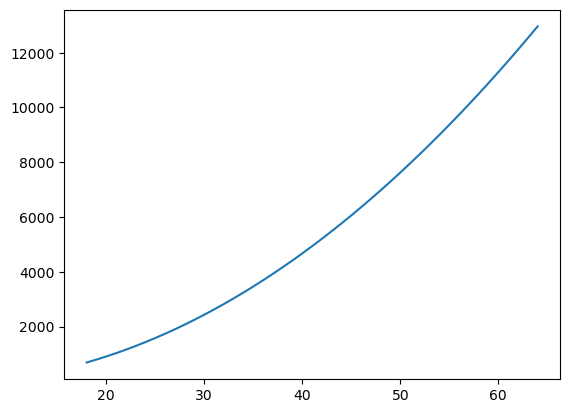

In [151]:
#問題6(2)
xs=np.unique(np.sort(df["age"]))
ys=-26*xs+3.57*xs**2
plt.plot(xs,ys)
plt.show()

では、sumamry()メソッドで回帰分析の詳細を調べてみます。

#### 問題6(3) result_allの回気分析の結果をsummary()メソッドで調べてみよ。

.tables変数にリストとして回帰分析の結果が入っています。

.tables[0]:回帰分析概要＆結果

.tables[1]:回帰係数の推定・検定結果



In [152]:
#問題6(3)
#重回帰モデルの推定結果
print(result_all.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     416.8
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:34:13   Log-Likelihood:                -13527.
No. Observations:                1338   AIC:                         2.708e+04
Df Residuals:                    1327   BIC:                         2.713e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         


tables[0]変数には推定結果の概略がまとめられています。決定係数(R-squared),修正決定係数(Afj. R-squared)は0.76なので、すべての説明変数を用いた重回帰モデルで売上の変化の76\%を記述していることが分かります。

F値(F-statisics)の検定の結果もp値がゼロなので、すべての回帰係数がゼロという帰無仮設が棄却されることが分かります。

他に、データ数(No. Observations:n=1338)、モデルの自由度(Df Models)＝説明変数の個数(p)=10,残差の自由度(Df Residuals:n-(p+1)=1327),などが表示されています。

F値は次の式で計算します。

$$
\mbox{F値(F-statistics)}=\frac{\mbox{予測値の偏差平方和}/\mbox{Df_Model}}{\mbox{残差平方和}/\mbox{Df_Residulals}}
$$

#### 問題6(4) F値を計算し,F_valueに代入し表示せよ。

In [153]:
#問題6(4)
#予測値を計算しpred_allに代入。
pred_all=result_all.predict()
#残差を計算しerror_allに代入
error_all=df["y"]-pred_all
#サンプルサイズ
n=1338
#説明変数の個数（モデルの自由度）
Df_Model=10
#残差の自由度
Df_Residuals=n-Df_Model-1
#F値の計算
F_value=(np.sum((pred_all-np.mean(pred_all))**2)/Df_Model)/(np.sum(error_all**2)/(Df_Residuals))
print(F_value)

416.8327582986608


#### 問題6(5)predict_allをdfの"predict_all"列として追加せよ。そして、予測値と目的変数の散布図をプロットせよ。

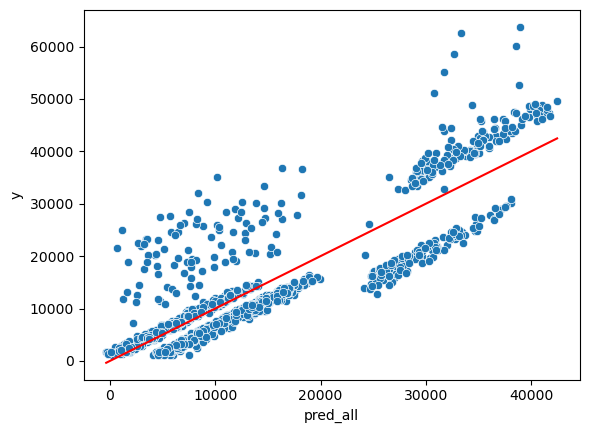

In [154]:
#問題6(5)
#predict_allをdfの"predict_all"列として追加せよ。そして、予測値と目的変数の散布図をプロットせよ。
df["pred_all"]=result_all.predict()
#pred_llとyのscatterplot
sns.scatterplot(x="pred_all",y="y",data=df)
#対角線をプロット
x_min=pred_all.min()
x_max=pred_all.max()
plt.plot([x_min,x_max],[x_min,x_max],color="r")
plt.show()

#### 問題6(6)error_allのヒストグラムをプロットせよ。

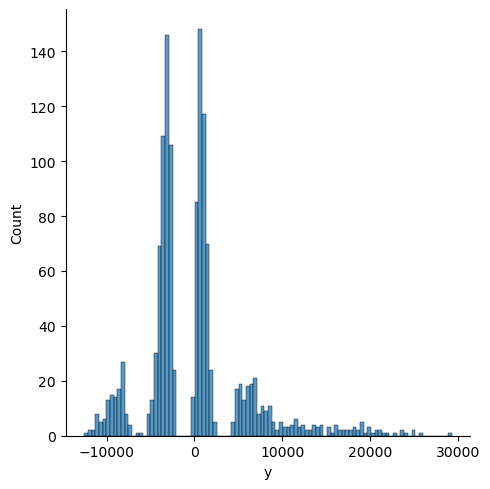

In [155]:
#問題6(6)
#error_allのヒストグラムをプロットせよ。
sns.displot(error_all,bins=100)
plt.show()


---

## 3.交互作用を持つモデル


説明変数age,sex,bmi,children,smoker,region,bmi30,age_sq間の相互作用をモデルに取り入れます。特に、smokerとbmi,bmi30間の相互作用をモデルに組み込んでみます。

$$
y=b_{0}+\sum_{i=1}^{p}b_i\cdot x_i+\epsilon
$$

$$
y=b_{0}+\sum_{i=1}^{p}b_{i}\cdot x_i+b_{p+1}\mbox{smoker}\cdot\mbox{bmi30}
+b_{p+2}\mbox{smoker}\cdot \mbox{bmi}+\epsilon
$$

よって、説明変数の個数(Df_Model)は全部で$12$になります。
モデルのパラメータ数$p=13$です。


#### 問題7交互作用の入ったモデルを構築し推定せよ。推定結果をresult_all_intに代入すること。

In [156]:
#交互作用の入ったモデルを構築し推定せよ
result_all_int = smf.ols("y ~ age + sex+ bmi+ children +smoker+region+bmi30+age_sq+smoker*bmi30+smoker*bmi",data=df).fit()

#### 問題7(1)回帰係数の推定結果を表示せよ。

In [157]:
#問題7(1)
#回帰係数の推定結果を表示せよ。
print(result_all_int.summary().tables[1])

                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    2571.3600   1401.358      1.835      0.067    -177.763    5320.483
sex[T.male]                  -521.2918    239.990     -2.172      0.030    -992.093     -50.490
smoker[T.yes]                1402.3140   2074.378      0.676      0.499   -2667.110    5471.738
region[T.northwest]          -382.5926    343.369     -1.114      0.265   -1056.199     291.014
region[T.southeast]          -893.7136    345.398     -2.587      0.010   -1571.301    -216.127
region[T.southwest]         -1196.7013    344.160     -3.477      0.001   -1871.859    -521.543
bmi30[T.True]                  33.1938    446.508      0.074      0.941    -842.745     909.133
smoker[T.yes]:bmi30[T.True]  1.514e+04   1000.100     15.142      0.000    1.32e+04    1.71e+04
age                           -15.0178  

#### 問題7(2)重回帰モデルの推定結果を表示せよ。決定係数など。

In [158]:
#問題7(2)
#重回帰モデルの推定結果（決定係数、F値など）
print(result_all_int.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     747.7
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:34:13   Log-Likelihood:                -13106.
No. Observations:                1338   AIC:                         2.624e+04
Df Residuals:                    1325   BIC:                         2.631e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         


#### 問題7(3)予測値を計算しpredict_all_intに、残差を計算しerror_all_intに代入せよ。F値を定義に従って計算して表示し、推定結果と一致することを確認せよ。

In [159]:
#問題7(3)
#F値を定義に従って計算して表示
pred_all_int=result_all_int.predict()
error_all_int=df["y"]-pred_all_int
n=1338
Df_Model=12
Df_Residuals=n-Df_Model-1
F_value=(np.sum((pred_all_int-np.mean(pred_all_int))**2)/Df_Model)/(np.sum(error_all_int**2)/(Df_Residuals))
print(F_value)

747.7102285996018


#### 問題7(4)predict_all_intをdfの"predict_all_int"列として追加せよ。そして、予測値と目的変数の散布図をプロットせよ。

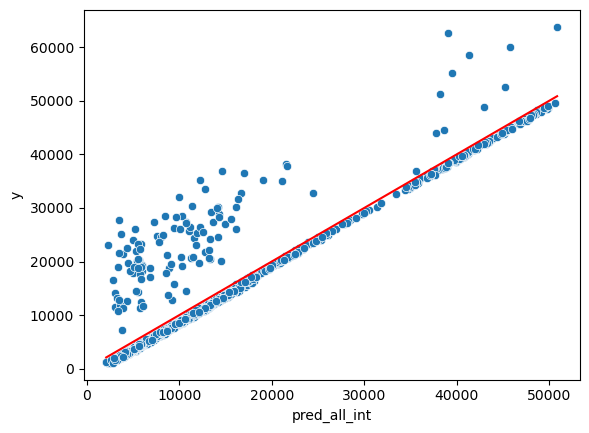

In [160]:
#問題7(4)
#予測値をdfの"predict_all_int"列として追加
df["pred_all_int"]=result_all_int.predict()
#pred_all_intとyのscatterplot
sns.scatterplot(x="pred_all_int",y="y",data=df)
#対角線をプロット
x_min=pred_all_int.min()
x_max=pred_all_int.max()
plt.plot([x_min,x_max],[x_min,x_max],color="r")
plt.show()

#### 問題7(5)error_all_intをerror_all_int列としてdfに追加せよ。また、残差のヒストグラムをプロットせよ。

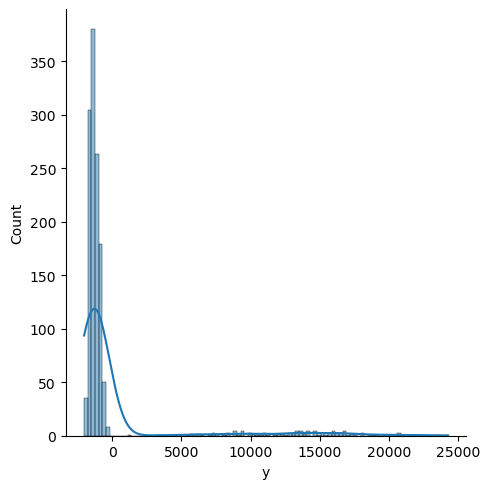

In [161]:
#問題7(5)
#残差をerror_all_int列としてdfに追加せよ。また、残差のヒストグラムをプロット
df["error_all_int"]=error_all_int
sns.displot(error_all_int,bins=100,kde=True)
plt.show()

#### 問題7(6)error_all_intが10000以上の人数をカウントし、error_all_int_over_10000に代入し表示せよ。

In [162]:
#問題7(6)
error_all_int_over_10000=sum(df["error_all_int"]>10000)
print(error_all_int_over_10000)

84


## 4. 練習

#### 問題8:次の医療費データセットで医療費の重回帰モデルを構築せよ。モデル自由度が8以下で決定係数99.9\%以上のモデルとする。

/tmp/ipykernel_327074/3054087852.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_age=np.round(np.random.normal(size=n,loc=45,scale=10)).astype(np.int)
/tmp/ipykernel_327074/3054087852.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

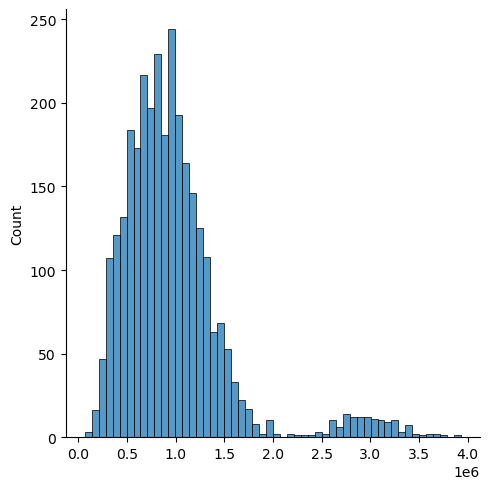

               age          bmi     children             y
count  3000.000000  3000.000000  3000.000000  3.000000e+03
mean     45.253667    24.978433     1.566667  9.691487e+05
std      10.141907     9.990120     1.300815  5.574149e+05
min      11.000000    -7.800000     0.000000  6.480000e+04
25%      38.000000    18.300000     1.000000  6.261000e+05
50%      45.000000    25.200000     1.000000  8.732000e+05
75%      52.000000    31.700000     2.000000  1.152000e+06
max      87.000000    55.800000     5.000000  3.933200e+06


In [163]:
# 医療費データ生成
import numpy as np
np.random.seed(1)
n=3000
sexs=["male","female"]
regions=["hirosaki","goshogawara","aomori","hachinohe","towada"]
yn=["yes","no"]
salts=["like","dislike"]
confs=["yes","no"]
#DATA
x_male=np.random.choice([1,0],n,p=[0.52,0.48])
sex=[]
for x in x_male:
  sex.append(sexs[x])

x_region=np.random.choice([0,1,2,3,4],n,p=[0.25,0.1,0.35,0.25,0.05])
region=[]
for x in x_region:
  region.append(regions[x])

x_smoker=np.random.choice([1,0],n,p=[0.1,0.9])
smoker=[]
for x in x_smoker:
  smoker.append(yn[x])

x_child=np.random.choice([0,1,2,3,4,5],n,p=[0.2,0.4,0.2,0.1,0.05,0.05])

x_par=np.random.choice([1,0],n,p=[0.3,0.7])
parent=[]
for x in x_par:
  parent.append(yn[x])

x_bmi=np.round(np.random.normal(size=n,loc=25,scale=10),1)
x_age=np.round(np.random.normal(size=n,loc=45,scale=10)).astype(np.int)

x_salt=np.random.choice([1,0],n,p=[0.7,0.3])
salt=[]
for x in x_salt:
  salt.append(salts[x])

x_conf=np.random.choice([1,0],n,p=[0.7,0.3])
conf=[]
for x in x_conf:
  conf.append(confs[x])

y=np.round(1000*x_smoker+2000*x_salt+10000*x_salt*x_smoker+3000*x_age+200*x_age**2+10000*x_salt*x_age+2000000*(x_bmi>40)*x_salt,-2).astype(np.int)

sns.displot(y,kde=False)
plt.show()

df2=pd.DataFrame({"sex":sex,"age":x_age,"smoker":smoker,"bmi":x_bmi,"children":x_child,"parent":parent,"salty":salt,"self_conf":conf,"region":region,"y":y})
print(df2.describe())
df2.head()
df2.to_csv('insurance2.csv', index=False)

In [164]:
#WEB上のcsvデータを読み込んでデータフレームとする。
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
import urllib.request
from io import StringIO
#WEB上のデータのURLを指定
url = "https://raw.githubusercontent.com/CS-Advanced/DATA/main/insurance2.csv"
#url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
#データを読み込む関数を定義
def read_csv(url):
    print(url)
    res = urllib.request.urlopen(url)
    res = res.read().decode("utf-8")
    df = pd.read_csv(StringIO(res))
    return df
df=read_csv(url)
df= df.astype({"sex":"category","smoker":"category","salty":"category","parent":"category","self_conf":"category","region":"category"})
df.info()

https://raw.githubusercontent.com/CS-Advanced/DATA/main/insurance2.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   sex        3000 non-null   category
 1   age        3000 non-null   int64   
 2   smoker     3000 non-null   category
 3   bmi        3000 non-null   float64 
 4   children   3000 non-null   int64   
 5   parent     3000 non-null   category
 6   salty      3000 non-null   category
 7   self_conf  3000 non-null   category
 8   region     3000 non-null   category
 9   y          3000 non-null   int64   
dtypes: category(6), float64(1), int64(3)
memory usage: 112.3 KB


In [165]:
# 複数の説明変数を持つモデルを推定する
df["age_sq"]=df["age"]**2
df["bmi40"]=df["bmi"]>40
df.head()

,sex,age,smoker,bmi,children,parent,salty,self_conf,region,y,age_sq,bmi40
0,female,61,yes,26.0,1,no,dislike,yes,hachinohe,1539200,3721,False
1,male,50,yes,31.2,1,yes,like,yes,hirosaki,650000,2500,False
2,female,37,yes,18.9,0,no,dislike,yes,hirosaki,756800,1369,False
3,female,31,yes,25.4,0,no,dislike,yes,towada,597200,961,False
4,female,38,yes,45.1,3,yes,dislike,no,towada,2784800,1444,True


In [166]:
result= smf.ols("y ~ age*smoker*bmi40*salty*age_sq",data=df).fit()
result.summary().tables[0]

Dep. Variable:,y,R-squared:,1.000
Model:,OLS,Adj. R-squared:,1.000
Method:,Least Squares,F-statistic:,3.393e+22
Date:,"Thu, 01 Jun 2023",Prob (F-statistic):,0.00
Time:,23:34:15,Log-Likelihood:,27026.
No. Observations:,3000,AIC:,-5.399e+04
Df Residuals:,2968,BIC:,-5.380e+04
Df Model:,31,,
Covariance Type:,nonrobust,,


In [167]:
#正解 1000*x_smoker+2000*x_salt+10000*x_salt*x_smoker+3000*x_age+200*x_age**2+10000*x_salt*x_age+2000000*(x_bmi>40)*x_salt
result= smf.ols("y ~ smoker+salty+salty*smoker+age+age_sq+salty*age+bmi40*salty",data=df).fit()
result.summary().tables[0]

Dep. Variable:,y,R-squared:,1.000
Model:,OLS,Adj. R-squared:,1.000
Method:,Least Squares,F-statistic:,6.307e+29
Date:,"Thu, 01 Jun 2023",Prob (F-statistic):,0.00
Time:,23:34:15,Log-Likelihood:,50089.
No. Observations:,3000,AIC:,-1.002e+05
Df Residuals:,2991,BIC:,-1.001e+05
Df Model:,8,,
Covariance Type:,nonrobust,,


In [168]:
#Df Models 8
#Adj. R-squared:1.000　で合格
result.summary().tables[0]

Dep. Variable:,y,R-squared:,1.000
Model:,OLS,Adj. R-squared:,1.000
Method:,Least Squares,F-statistic:,6.307e+29
Date:,"Thu, 01 Jun 2023",Prob (F-statistic):,0.00
Time:,23:34:15,Log-Likelihood:,50089.
No. Observations:,3000,AIC:,-1.002e+05
Df Residuals:,2991,BIC:,-1.001e+05
Df Model:,8,,
Covariance Type:,nonrobust,,


#### 問題8採点セル　推定結果をresultに代入せよ。そして、次のセルを実行すること。

In [180]:
#問題8
#最後に次を実行すること。ここの表示で採点する。
#Df Models 8
#Adj. R-squared:1.000　で合格
print(f"Df Models: {result.df_model}")
print(f"Adj. R-squared: {result.rsquared_adj}")

Df Models: 8.0
Adj. R-squared: 1.0


In [170]:
list(df.columns)

['sex',
 'age',
 'smoker',
 'bmi',
 'children',
 'parent',
 'salty',
 'self_conf',
 'region',
 'y',
 'age_sq',
 'bmi40']

In [171]:
desc_list =['sex','age','smoker','bmi','children','parent','salty','self_conf','region','age_sq','bmi40','smoker*age','salty*smoker','bmi40*salty','bmi40*age','salty*age']

In [172]:
# descriptorsの説明変数のリストからnum個の組み合わせすべてを作成し
# 回帰モデルのformulaの文字列オブジェクトにします。
def generate_formulas(descriptors, num):
    import itertools
    if num > len(descriptors):
        return None
    else:
        for f in itertools.combinations(descriptors, num):
            formula = 'y ~ ' + ' + '.join(f)
            yield formula

## 出力リスト
n_var = []
formula = []
AIC = []
adj_r2 = []
## Nullモデル作成
null_model = smf.ols(formula='y ~ 1', data=df).fit()
n_var.append(0)
formula.append('y ~ 1')
AIC.append(null_model.aic)
adj_r2.append(null_model.rsquared_adj)

## 利用する記述子の数を変えながらモデル作成
for i in range(1,5):
    for f in generate_formulas(desc_list, i):
        m = smf.ols(formula=f, data=df).fit()
        n_var.append(i)
        formula.append(f)
        AIC.append(m.aic)
        adj_r2.append(m.rsquared_adj)

df_model = pd.DataFrame({'n_var': n_var,'formula': formula,'aic': AIC,'adj_r2': adj_r2})

In [173]:
df_model.sort_values(by="aic")[0:3]

,n_var,formula,aic,adj_r2
2499,4,y ~ age_sq + salty*smoker + bmi40*salty + salt...,-95481.643305,1.000000
2496,4,y ~ age_sq + smoker*age + bmi40*salty + salty*age,51996.005615,0.999994
1780,4,y ~ smoker + age_sq + bmi40*salty + salty*age,52003.935701,0.999994


In [174]:
result= smf.ols("y ~ age+age_sq+salty+smoker+salty*smoker+bmi40+bmi40*salty+salty*age",data=df).fit()
result.summary().tables[0]

Dep. Variable:,y,R-squared:,1.000
Model:,OLS,Adj. R-squared:,1.000
Method:,Least Squares,F-statistic:,6.966e+28
Date:,"Thu, 01 Jun 2023",Prob (F-statistic):,0.00
Time:,23:34:26,Log-Likelihood:,46785.
No. Observations:,3000,AIC:,-9.355e+04
Df Residuals:,2991,BIC:,-9.350e+04
Df Model:,8,,
Covariance Type:,nonrobust,,


In [175]:
def stepAIC(descs_l,data):
    import copy
    descriptors = descs_l
    f_model = smf.ols(formula='y ~ ' + ' + '.join(descriptors), data=data).fit()
    best_aic = f_model.aic
    best_model = f_model
    while descriptors:
        desc_selected = ''
        flag = 0
        for desk in descriptors:
            used_desks = copy.deepcopy(descriptors)
            used_desks.remove(desk)
            formula = 'y ~ ' + ' + '.join(used_desks)
            model = smf.ols(formula=formula, data=data).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_model = model
                desc_selected = desk
                flag = 1
        if flag:
            descriptors.remove(desc_selected)
        else:
            break
    return best_model

model_a = stepAIC(desc_list,df)
print(model_a.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.069e+31
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:34:27   Log-Likelihood:                 56461.
No. Observations:                3000   AIC:                        -1.129e+05
Df Residuals:                    2982   BIC:                        -1.128e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [176]:
result= smf.ols("y ~ smoker+salty+bmi40+salty*smoker+age_sq+age+salty*age+bmi40*salty",data=df).fit()
result.summary().tables[0]

Dep. Variable:,y,R-squared:,1.000
Model:,OLS,Adj. R-squared:,1.000
Method:,Least Squares,F-statistic:,2.925e+29
Date:,"Thu, 01 Jun 2023",Prob (F-statistic):,0.00
Time:,23:34:27,Log-Likelihood:,48937.
No. Observations:,3000,AIC:,-9.786e+04
Df Residuals:,2991,BIC:,-9.780e+04
Df Model:,8,,
Covariance Type:,nonrobust,,
